Student name:

Student ID:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss


These functions are provided to assist you in Task 1a

In [2]:
def point_on_boundary(weights, x):
    """ Return the y-position on the boundary based on given x-position.  """
    return -(weights[0]+weights[1]*x)/weights[2]

In [3]:
def decision_boundary(weights, x_min, x_max):
    """ Return two points on the decision boundary: one at x_min and one at x_max """
    return [pointOnBoundary(x_min), pointOnBoundary(x_max)]

In [4]:
#Also useful in Task 2!
def transPoly(X, power):
    # Extend the data in X with a bias (1) and powers of the feature up to 'power'
    ones = np.ones((X.shape[0],1))
    extra=[]
    for x in X:
        row=[]
        for p in range(2,power+1):
            row.append(x**p)
        extra.append(row)
    return np.concatenate((ones, X.reshape(len(X),1),np.array(extra)),1)

In [5]:
def calc_stats(clf, X_train, y_train, X_test, y_test, poly_order=1):
    '''
        calculate the score and error for both in and out of sample
        arguments:
            clf: pre-trained classifier that predicts out based on input data
            X_train: training input data
            y_train: training output data
            X_test: testing input data
            y_test: testing output data
            poly_order: the number of polynomial
        return:
            [number of features, in-sample-score, out-of-sample-score, in-sample-error, out-of-sample-error]
    '''
    poly = PolynomialFeatures(poly_order)
    X_train_tran = poly.fit_transform(X_train)
    X_test_tran = poly.fit_transform(X_test)
    e_in = log_loss(y_train, clf.predict(X_train_tran))
    e_out = log_loss(y_test, clf.predict(X_test_tran))
    score_in = clf.score(X_train_tran, y_train)
    score_out = clf.score(X_test_tran, y_test)
    return [X_train_tran.shape[1], score_in, score_out, e_in, e_out]

def get_wrong_prediction(X, y, y_hat):
    '''
        get the predictions that are wrong by comparing the y and predicted y
        arguments:
            X: the input to be stored when y prediction is wrong
            y: the original output
            y_hat: the predicted output
        return:
            list of wrong predictions, this list only consists of input data X 
    '''
    wrong_predict = []
    for idx, yi in enumerate(y):
        if yi != y_hat[idx]:
            wrong_predict.append(X[idx])
    return np.array(wrong_predict)

def plot_decison_boundary(ax, clf, X, y, poly_order, title):
    '''
        plots the boundary based on the classifier.
        this will plot the graph with a line(linear/non-linear) separating two groups of data(classification)
        each area will be plotted as a meshgrid -> the colored background
        this plot overlays the wrongly predicted data points with a cross to identify those data that are predicted wrongly
        arguments:
            ax: the plot which the graph is plotted to
            clf: pre-trained classifier
            X: input data
            y: output data
            poly_order: number of polynomials
            title: main title of the plot
    '''
    h = 0.005
    x_min, x_max = X[:, 0].min() - 10*h, X[:, 0].max() + 10*h
    y_min, y_max = X[:, 1].min() - 10*h, X[:, 1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    poly = PolynomialFeatures(poly_order)
    X_grid = np.hstack((np.expand_dims(xx.ravel(), 1), np.expand_dims(yy.ravel(), 1)))
    X_grid_train = poly.fit_transform(X_grid)
    Z = clf.predict(X_grid_train)
    Z = Z.reshape(xx.shape)

    X_trans = poly.fit_transform(X)
    y_pred = clf.predict(X_trans)
    X_wrong = get_wrong_prediction(X, y, y_pred)

    score = clf.score(X_trans, y)
    loss = log_loss(y, y_pred)

    ax.contourf(xx, yy, Z, cmap='Paired_r', alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linewidths=0.7)
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, s=90, cmap='flag')
    ax.scatter(X_wrong[:, 0], X_wrong[:, 1], marker='x', s=90, c='white')
    ax.set_title(f'{title} | Score: {round(score, 2)} | Error: {round(loss, 2)}')

def load_data(file_path):
    data = np.loadtxt(file_path, delimiter=",")
    X, y = data[:, 0:2], data[:, 2]
    return (X, y)


# Task 1a 
(Complete by Saturday, Feb 12th)
- ✔️Train scikit-learn’s Logistic Regression algorithm using the Et2_Classification_TrainingData.csv dataset provided in the repository without adding extra features to those provided. 
- ✔️Test the performance of your model using the Et2_Classification_TestData.csv dataset.
- ✔️Observe your results and explain why these results seem disappointing (record your thoughts in a Markdown cell in your notebook).
  - Answer: Logistic Regression is a linear model, it will not perform well on non linearly separable dataset.
- ✔️Now choose suitable new features and use these to improve the classification performance. Observe and explain (use plots where appropriate) why the classification performance has improved.
  - Answer: The X data is now transformed into the squared version (X1\*\*2, X2\*\*2). By doing this, we transformed the raw data into data that can be linearly separable as shown in the plot below.
- ✔️Try a few different transformations with and without committing the sin of "data snooping" and note the differences.


In [6]:
def classify_data(X_train, y_train, X_test, y_test, poly_order = 1):
    '''
        train and evaluate the performance for the model
        besides calculating the statistic of the mode, it will also plot the graph for each polynomial order
        arguments:
            X_train: training input data
            y_train: training output data
            X_test: testing input data
            y_test: testing output data
            poly_order: the number of polynomials
        return:
            the statistics for this model
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2)

    poly = PolynomialFeatures(poly_order)
    X_train_trans = poly.fit_transform(X_train)
    lr_clf = LogisticRegression(random_state=0)
    lr_clf.fit(X_train_trans, y_train)

    dvc = X_train_trans.shape[1]
    fig.suptitle(f'Decision Bounary | Polynomial Order: {poly_order} | VC Dimension: {dvc} | Required N: {dvc*10}', size=15)
    fig.set_figheight(10)
    fig.set_figwidth(30)

    plot_decison_boundary(ax1, lr_clf, X_train, y_train, poly_order, 'Training Data')
    plot_decison_boundary(ax2, lr_clf, X_test, y_test, poly_order, 'Testing Data')
    return calc_stats(lr_clf, X_train, y_train, X_test, y_test, poly_order)


#### Transformation & Classification without Data Snooping
We increase the d<sub>VC</sub> gradually without focusing on the pattern of the dataset

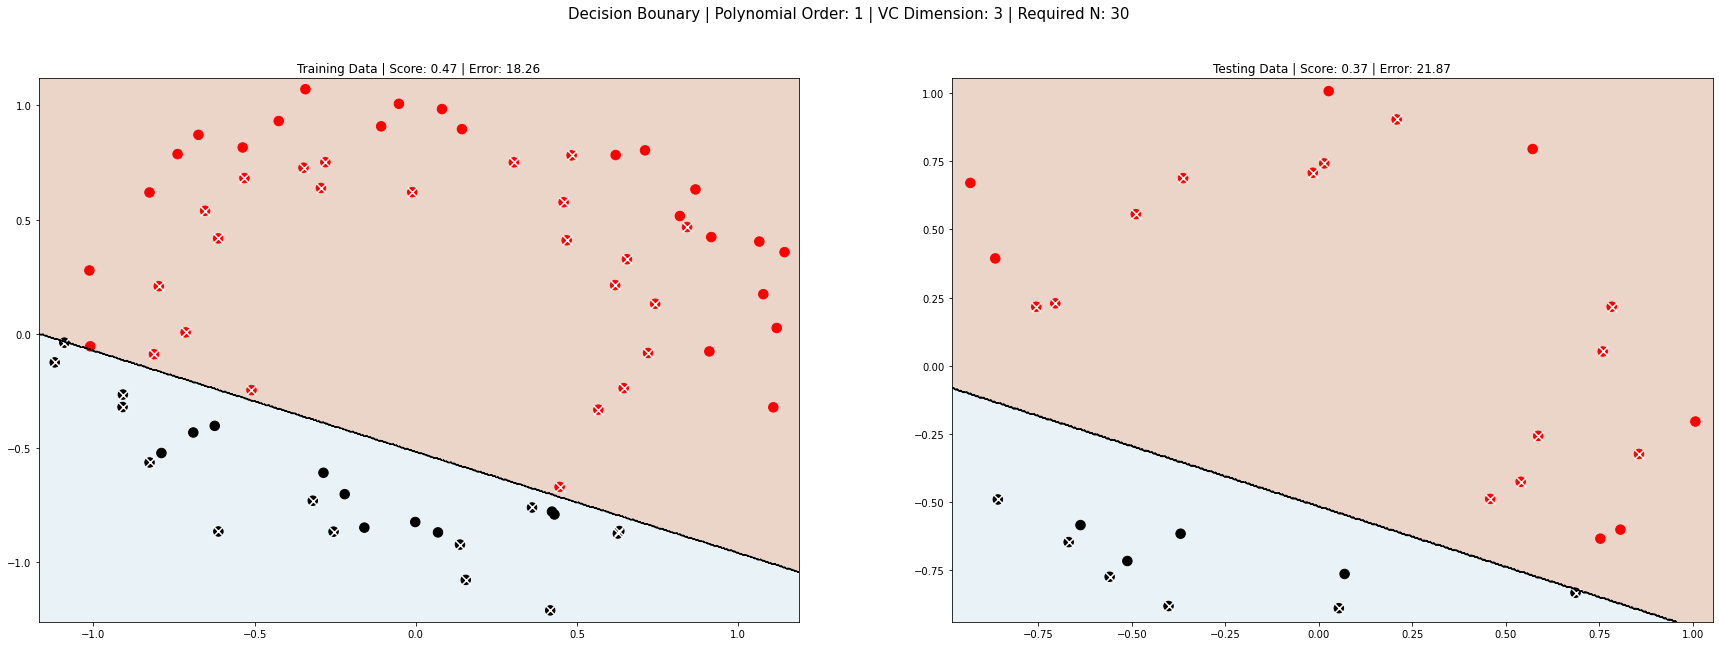

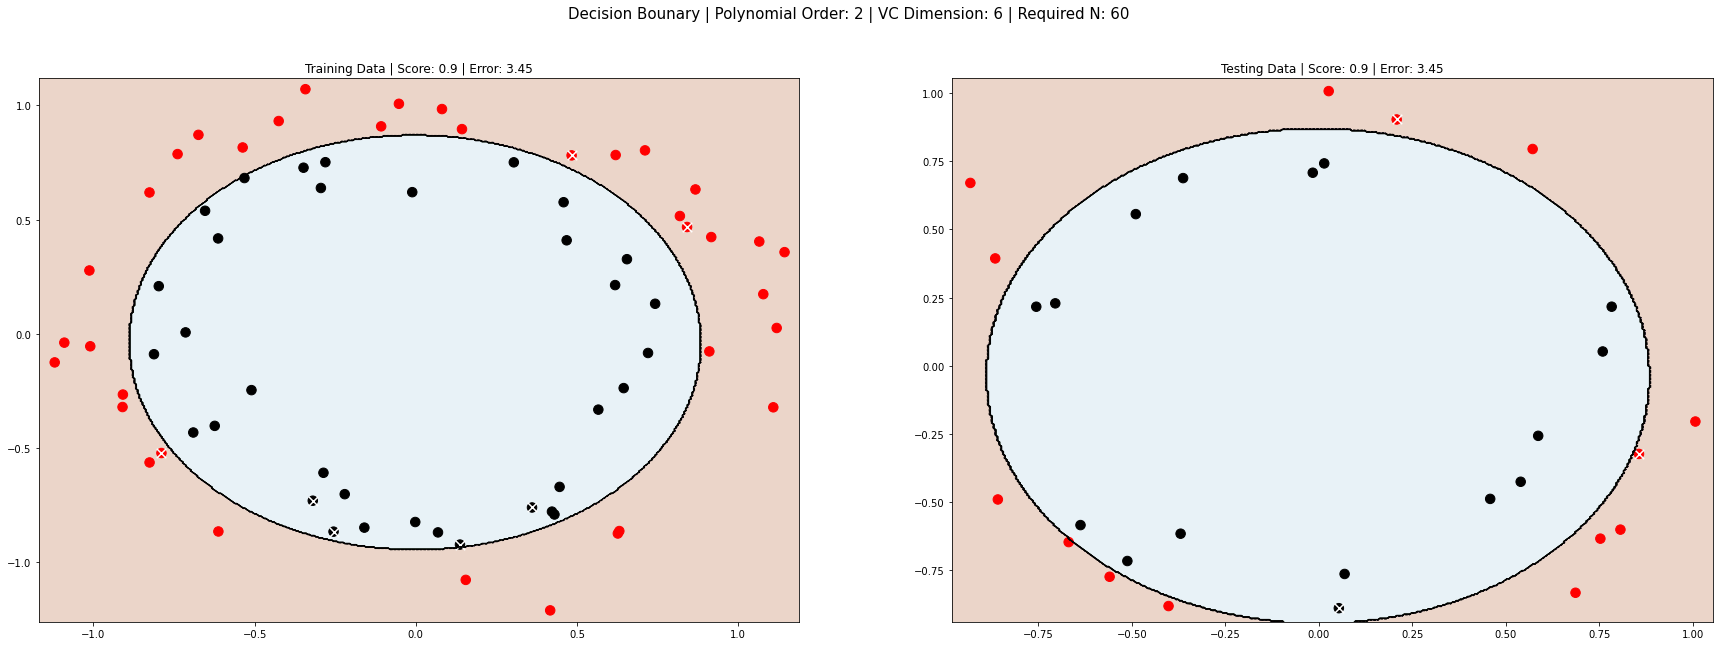

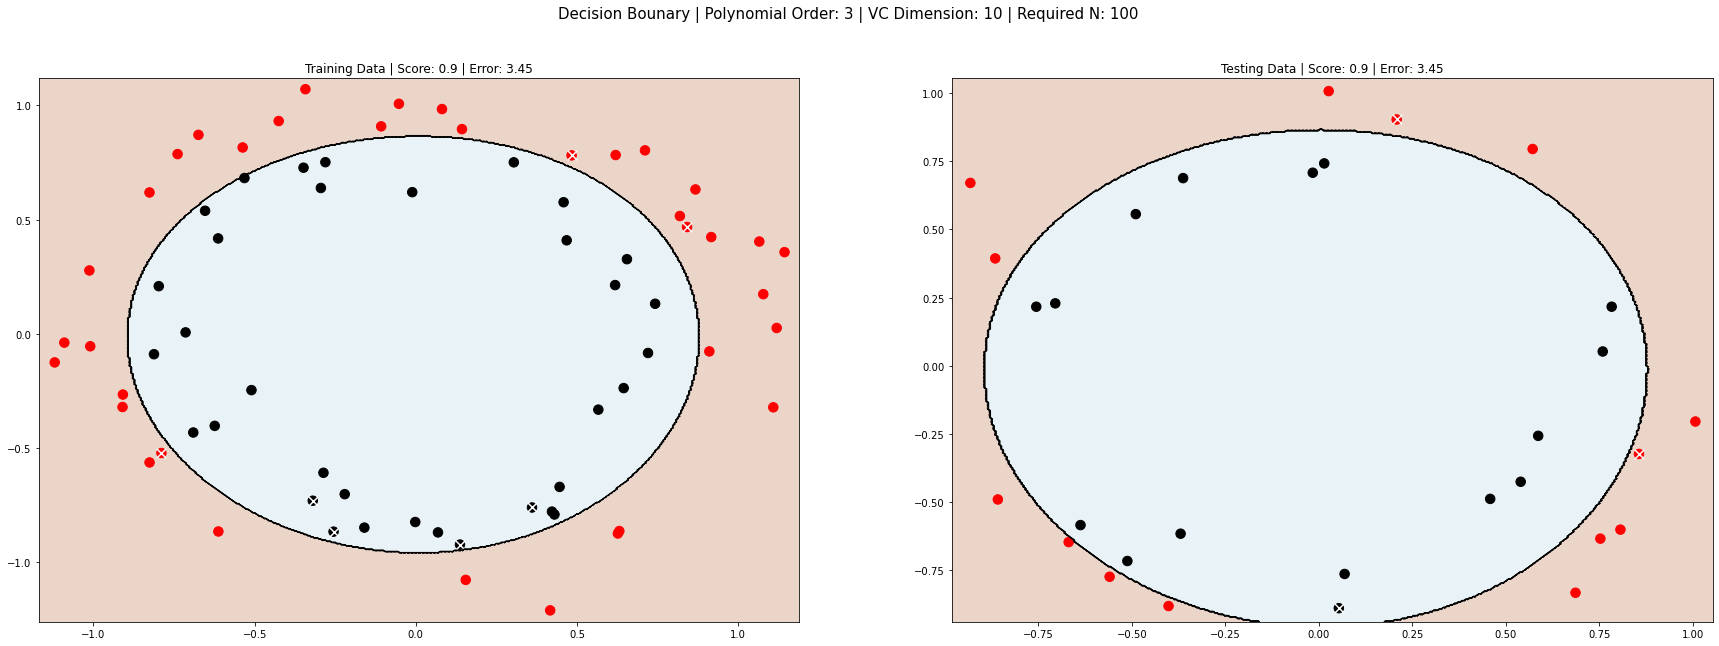

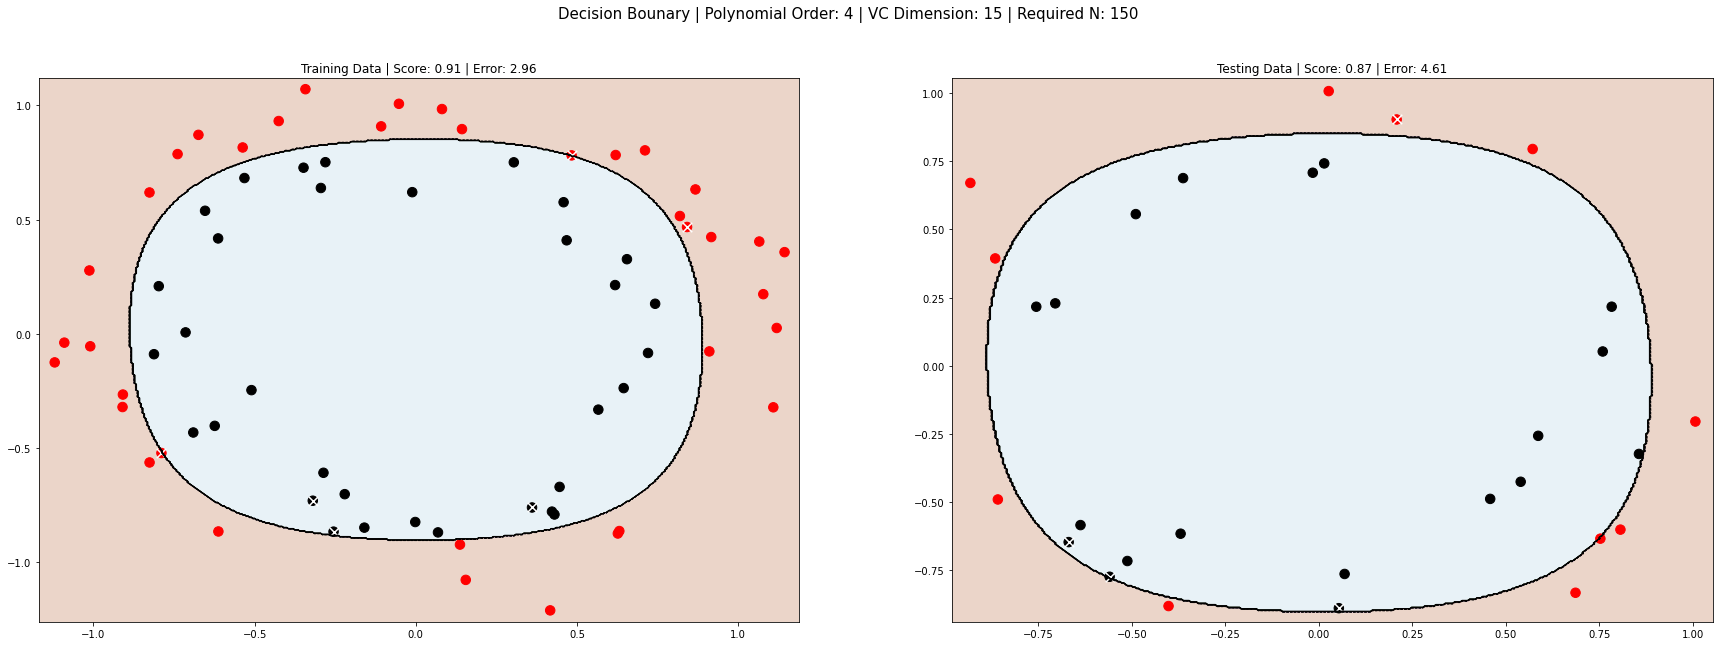

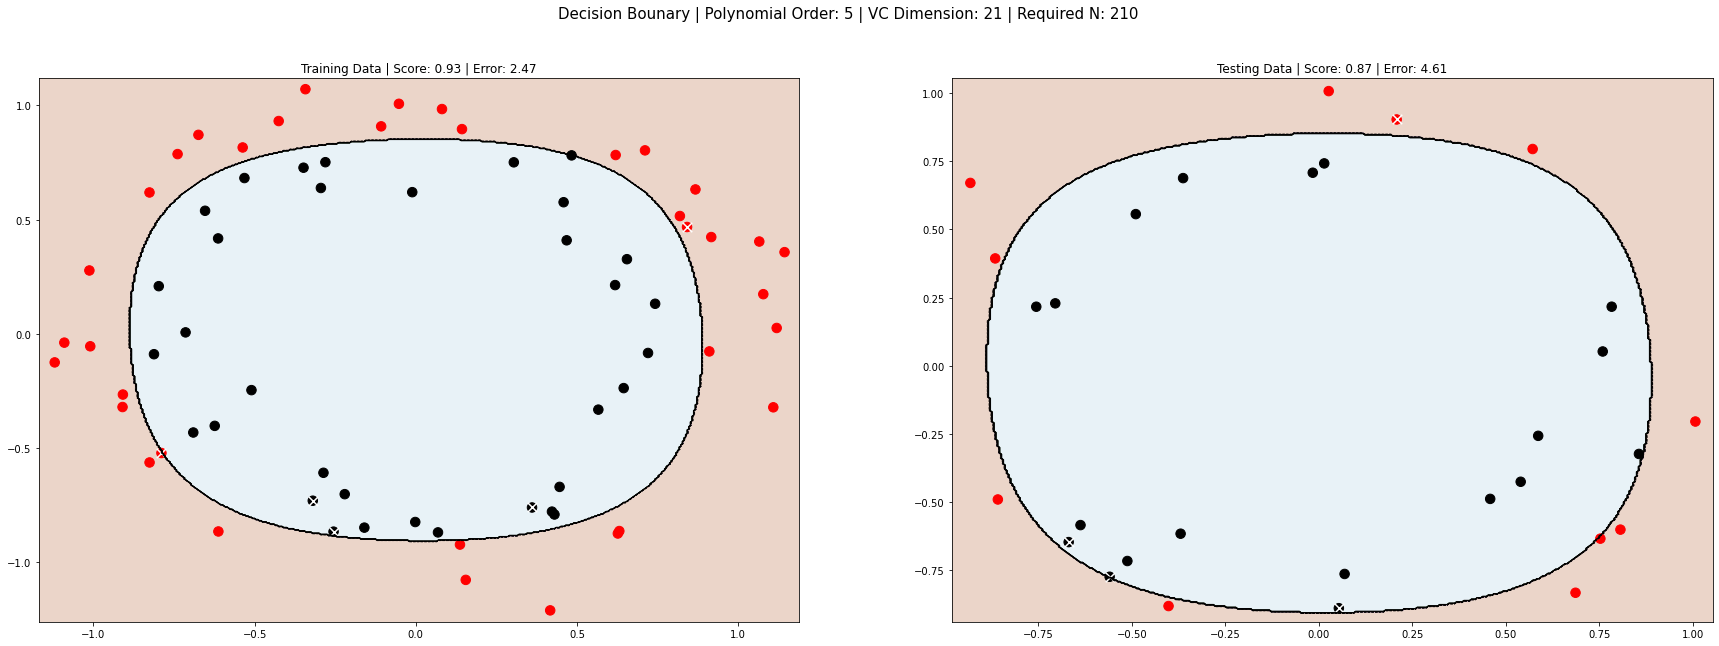

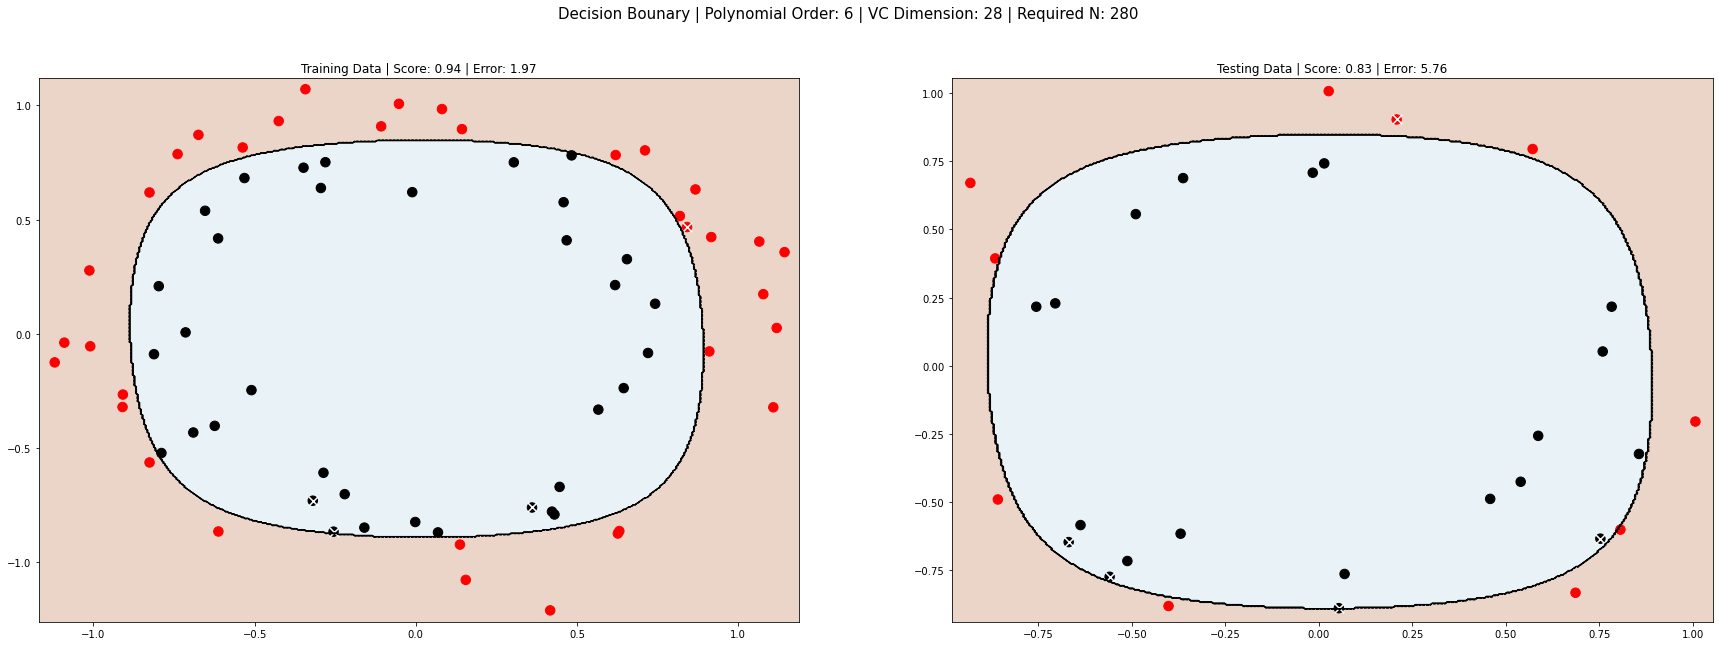

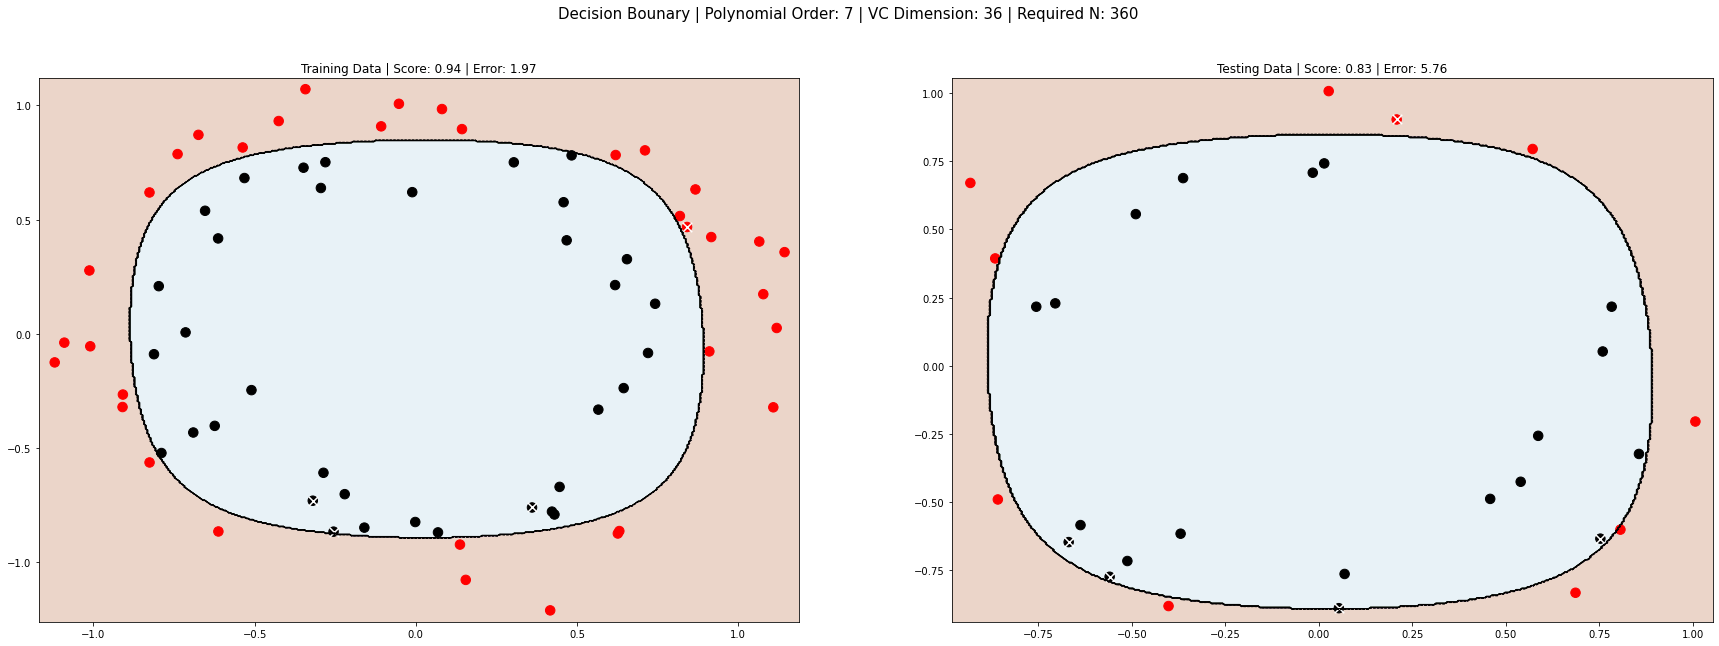

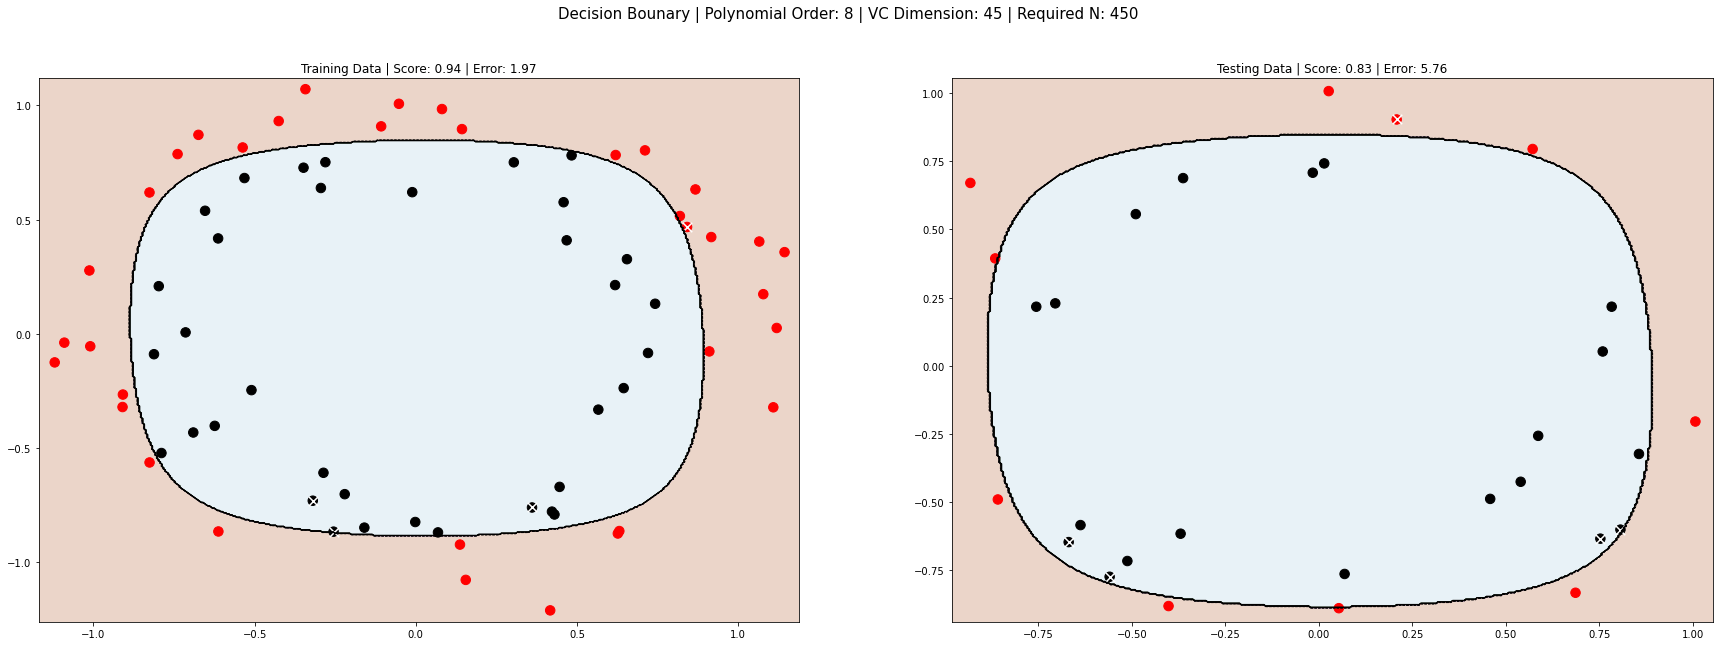

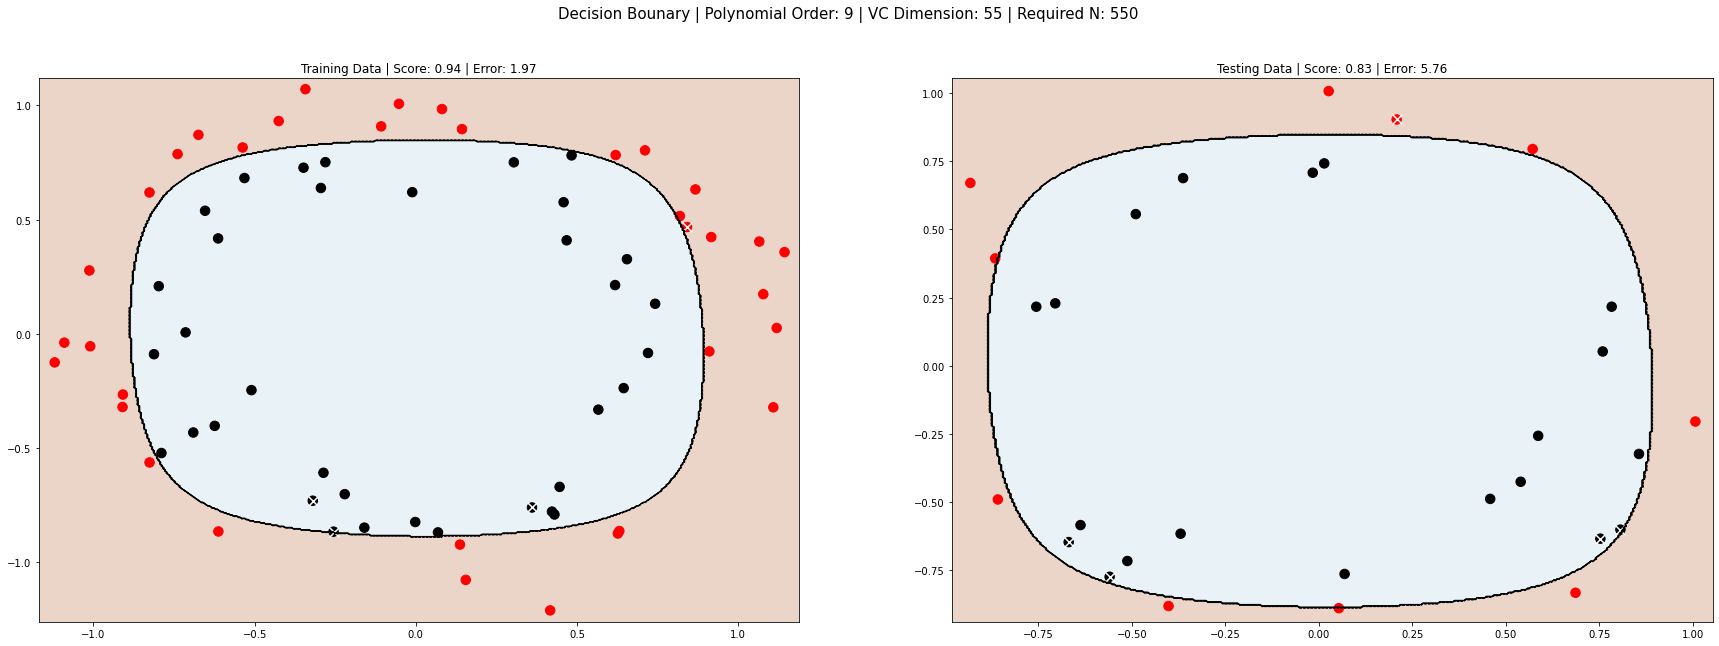

In [7]:
X_train, y_train = load_data('Et2_Classification_TrainingData.csv')
X_test, y_test = load_data('Et2_Classification_TestData.csv')

stats = []
for poly_order in range(1, 10):
    result = classify_data(X_train, y_train, X_test, y_test, poly_order)
    stats.append(result)
stats = np.array(stats)

#### Transformation & Classification with Data Snooping
We observe the dataset and use 2<sup>nd</sup> order polynomial as our model. And think that we only have 3 d<sub>VC</sub> instead of 6 d<sub>VC</sub>

In [8]:
lr_clf = LogisticRegression(random_state=0)
poly = PolynomialFeatures(2)
X_train_tran = poly.fit_transform(X_train)
X_train_tran_2_poly = X_train_tran[:, [0, 3, 5]]
X_test_tran = poly.fit_transform(X_test)
X_test_tran_2_poly = X_test_tran[:, [0, 3, 5]]

lr_clf.fit(X_train_tran_2_poly, y_train)
y_test_pred = lr_clf.predict(X_test_tran_2_poly)
y_train_pred = lr_clf.predict(X_train_tran_2_poly)

print("3 Feature Classification")
print(f'Score In-Sample: {lr_clf.score(X_train_tran_2_poly, y_train)}')
print(f'Score Out-Of-Sample: {lr_clf.score(X_test_tran_2_poly, y_test)}')
print(f'Error In-Sample: {log_loss(y_train, y_train_pred)}')
print(f'Error Out-Of-Sample: {log_loss(y_test, y_test_pred)}')


3 Feature Classification
Score In-Sample: 0.9142857142857143
Score Out-Of-Sample: 0.9
Error In-Sample: 2.960500816596496
Error Out-Of-Sample: 3.4539042927387418


#### Statistic Evaluation
Score_in, Score_out, E_in, E_out

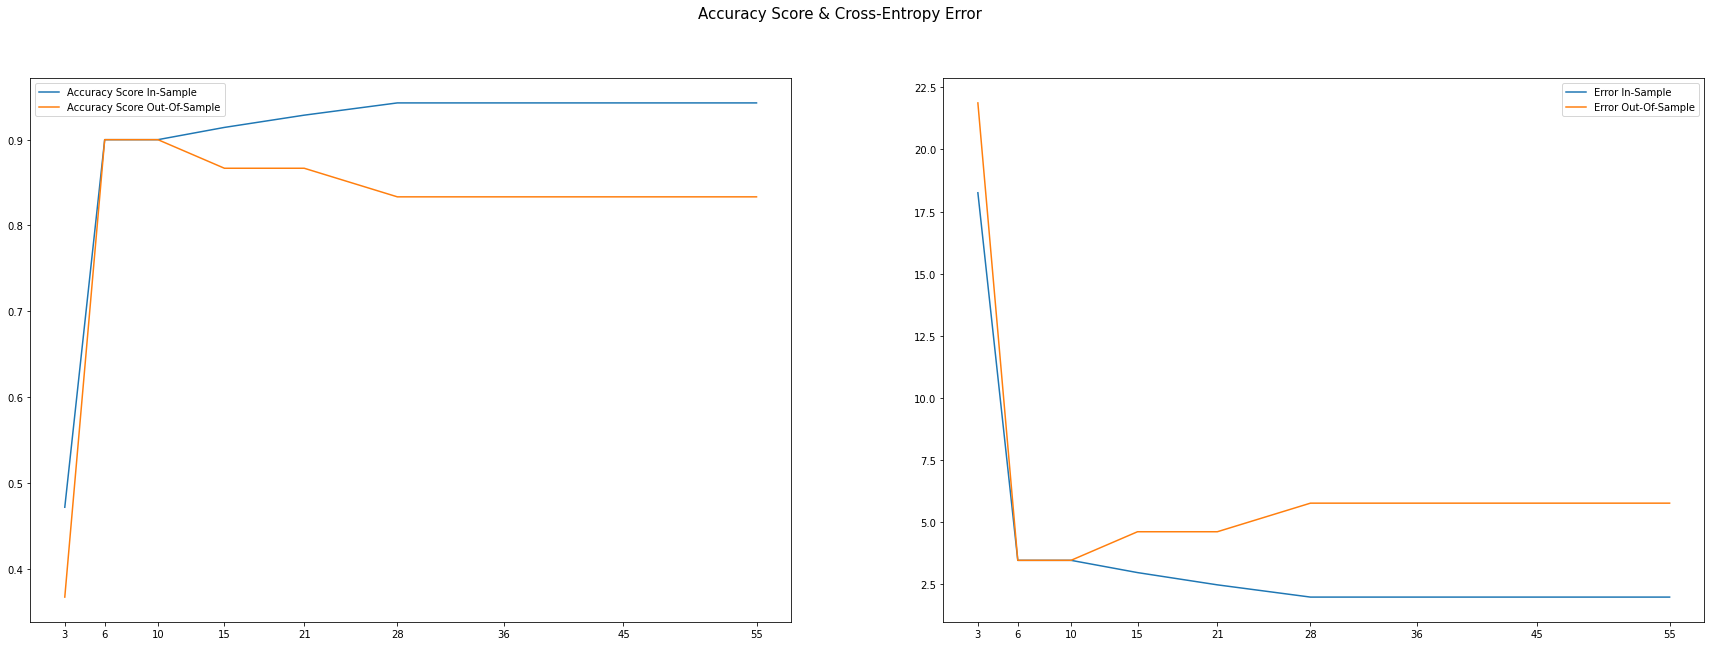

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Accuracy Score & Cross-Entropy Error', size=15)
fig.set_figheight(10)
fig.set_figwidth(30)

ax1.plot(stats[:, 0], stats[:, 1], label='Accuracy Score In-Sample')
ax1.plot(stats[:, 0], stats[:, 2], label='Accuracy Score Out-Of-Sample')
ax1.set_xticks(stats[:, 0])
ax1.legend()
ax2.plot(stats[:, 0], stats[:, 3], label='Error In-Sample')
ax2.plot(stats[:, 0], stats[:, 4], label='Error Out-Of-Sample')
ax2.set_xticks(stats[:, 0])
ax2.legend()


## Reflection

- Answer the following questions:
  - ✔️How do the found values for Ein and Eout for the various models relate to model complexity?
    - Before talking about the topic, one important thing to note is that the data we have is rather simple to separate. In such case, increase complexity of the beyond a certain extent will not have much improvement on performance. We can observe this from the above two plots. As the complexity increases(beyond 28 features), the errors and accuracy score stays rather flat.
    - Ein and Eout will likely to converge and decrease as the model becomes more complex in the begining stage(until 10 features).
    - Ein and Eout will likely to diverge as the model becomes more complex beyond the initial stage(past 10 features).
      - Ein will likely to decrease further as the model overfits the in sample data.
      - Eout will likely to increase as the model to not perform well on out of sample data.
  - ✔️Explain how data transformations can lead to linear separability of a dataset.
    - For our example, the original data is not linearly separable, without transforming the data, we can observe that the data should separable by drawing a circle around the center.
    - And if we change the features to X\*\*2, we are able to transform the data to be more linearly separable. This will move the points far away fom the center to 1 big group and points closer to the origin will stay as another group.
    - Linear models will still be able to work properly because the weights are linear despite the transformed data(Z) is no longer linear.
  - ✔️Explain how data transformations effect the complexity of your model.
    - By transforming the data, we are adding more features to the model hence increasing the model's complexity.
    - The reason why transforming always increase d<sub>VC</sub> is because even if we remove some of the features, we still need to account for those in d<sub>VC</sub>. Think of this as treating the removed features as having 0 weights.
    - When we increase model complexity, we have to ensure we have enough data to pay the cost of that. N >= d<sub>VC</sub> * 10

# Task 1b
(Complete by Saturday, Feb 12th)

- Split the dataset provided in Et2_Regression_Data.csv into a training and a test set (decide on a suitable ratio). 
- Use the provided linear regression algorithm to obtain the best possible fit to the training data set . 
- With the knowledge that the data source is a noisy polynomial with the highest order no lower than 5 and no higher than 10, use a structured approach to try different feature transformations. 
- Record the performance on training data and on test data.
- Use the results to decide on the data transformation that yields the best results.


In [10]:
def weights(X,y):
    # Calculation of weights using pseudo-inverse. Note that X needs to contain the bias of 1
    return np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)

In [11]:
def lin_reg(w,X):
    # Calculation of outputs given weights and data (X). Note that X needs to contain the bias of 1. 
    out=[]
    for x in X:
        out.append(w.T.dot(x))
    return np.array(out)

In [12]:
def calc_error(w,X,y):
    # Calculate the error as the mean squared error
    pred = lin_reg(w,X)
    return (pred-np.array(y)).dot(pred-np.array(y))/len(X)

To prevent results due to luck, it is useful to repeat your experiments a good few times and look at average results. The below code snippet may be useful in this regard.

In [13]:
# error_in = []
# error_out = []
# repeats = 100
# power_range = range(low_powers, high_powers) # it is up to you to decide on a suitable range

# for power in power_range: 
#     e_in=0
#     e_out=0
#     for r in range(repeats):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=XX) ##Choose a suitable training_size XX
#         X_train_trans = ## implement your data transformation 
#         X_test_trans = ## implement your data transformation 
#         w = weights(X_train_trans,y_train)
#         e_in += calc_error(w,X_train_trans,y_train)
#         e_out+= calc_error(w,X_test_trans,y_test)
#     error_in.append(e_in/repeats)
#     error_out.append(e_out/repeats)

## Reflection

- Answer the following questions:
  - How does the plot of Ein and Eout versus highest polynomial power relate to model complexity?
  - How can the choice of transformation that yielded the best results be explained in terms of sample complexity? 

Rubric: Suitable features used and systematic approach to finding these features. Well-considered answers to both questions.

# Task 2
(Complete by Saturday, Feb 12th)

For this task, the following is provided and should be made use of:

- ✔️the dataset in Et2_Regression_Data.csv
- ✔️function weights_reg to use linear regression with a regularization parameter
- ✔️a feature transformation function transPoly
- ✔️a code snippet suggesting how to keep track of Ein and Eout whilst trying various regularisers
- ✔️Use the provide function transPoly to obtain a weight vector of the original feature raised up to the power of 50
- ✔️Use the provided weights_reg function to perform linear regression on the data. 
- ✔️Using the provided code snippet, find the optimum regularization parameter, l. In order to do so, you will need to decide on a suitable list of l values. Pick at most 1000 values! Once you have found the optimal l, compare the Eout obtained with this l with the Eout obtained without regularization. You should see an impressive improvement!
- Provide the following plots:
  - ✔️A plot showing model performance vs l on the domain [0,1]
  - ✔️A plot with three sub-plots containing an overfitted model, a model with the optimal l, and an underfitted model. In each plot, you should plot the target function in addition to the final hypothesis. Choose values for l that clearly demonstrate over- and underfitting.


Below is an implementation of linear regression with regularization

In [14]:
def weights_reg(X,y,l):
    n = len(X)
    m=X.T.dot(X)
    return np.linalg.inv(m+l*np.identity(m.shape[0])).dot(X.T).dot(y)


This code snippet may be useful to keep track of Ein, Eout and the corresponding weights for various regulariser parameters

In [15]:
data = np.loadtxt('ET2_Regression_Data.csv', delimiter=",")
X, y = data[:, 0], data[:, 1]
X_trans = transPoly(X, 50)
lambda_start, lambda_end = 0.0001, 1
lambdas = np.linspace(lambda_start, lambda_end, 1000)
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, train_size=0.5, random_state=5)


In [16]:
def plot_subplot(ax, l, title, X_train, y_train):
    weight = weights_reg(X_train, y_train, l)
    y_pred = lin_reg(weight, X_trans)
    ax.scatter(X, y, label='Original Data')
    ax.scatter(X, y_pred, label='Predicted Data')
    ax.legend()
    ax.set_title(f'{title} - Lambda: {l}')


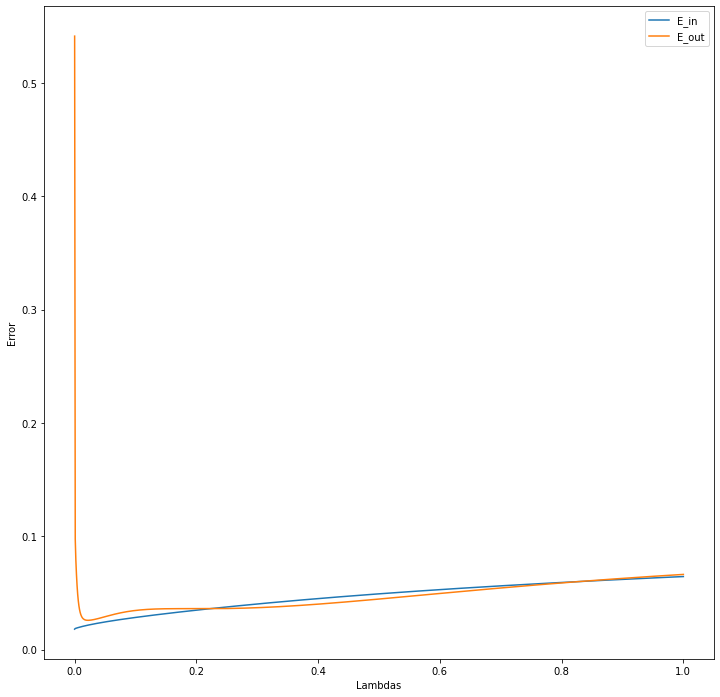

In [17]:
ein = []
eout = []
weights = []
for l in lambdas:
    w = weights_reg(X_train, y_train, l)
    ein.append(calc_error(w, X_train, y_train))
    eout.append(calc_error(w, X_test, y_test))
    weights.append(w)

figure(figsize=(12,12))
plt.plot(lambdas, ein, label='E_in')
plt.plot(lambdas, eout, label='E_out')
plt.xlabel('Lambdas')
plt.ylabel('Error')
plt.legend()
plt.show()


Minimum E_out: 0.02576354674577465 | E_in: 0.02151748405355879 | Lambda: 0.02211981981981982


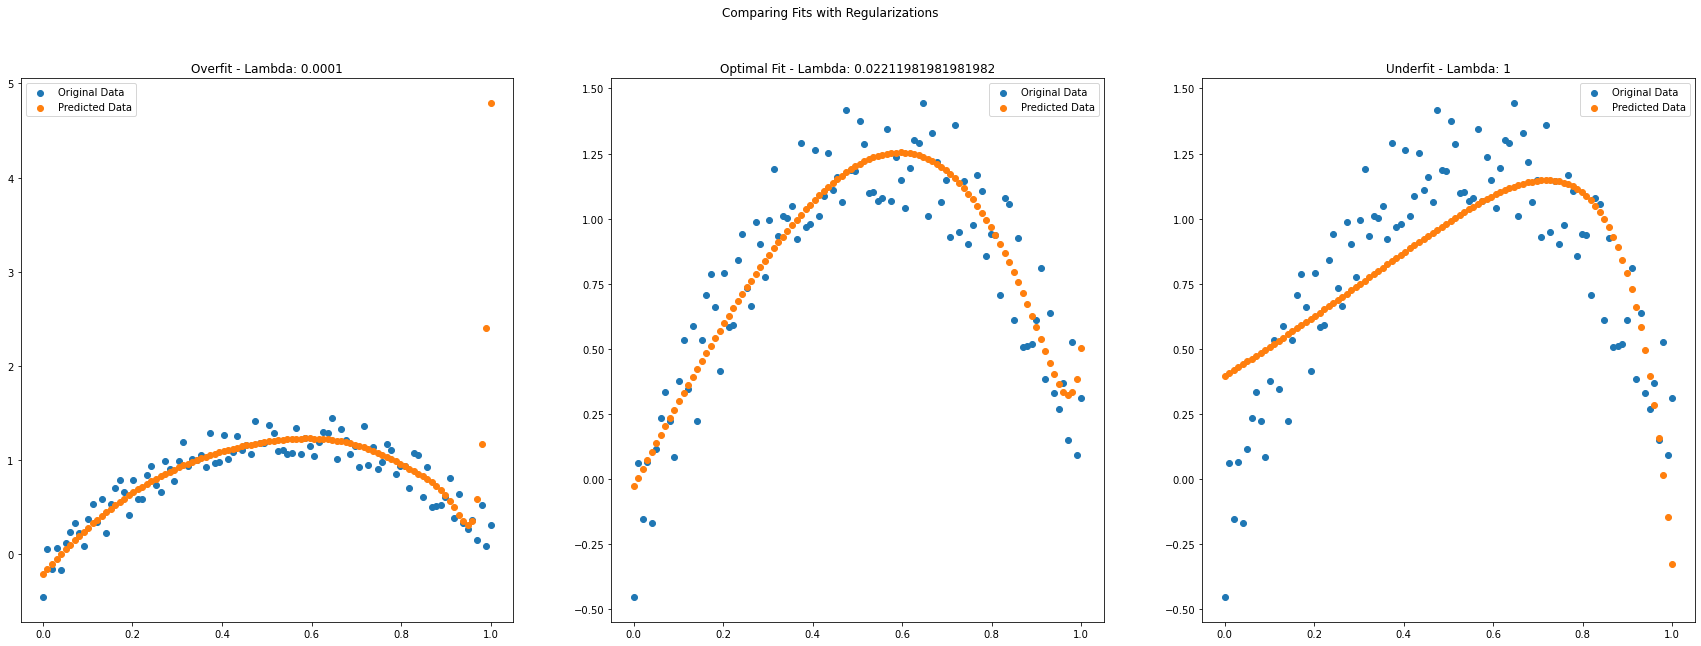

In [18]:
# find the best lambda by using lowest e_out
e_out_min = min(eout)
lambda_e_out_min = lambdas[eout.index(e_out_min)]
e_in_e_out_min = ein[eout.index(e_out_min)]
print(f'Minimum E_out: {e_out_min} | E_in: {e_in_e_out_min} | Lambda: {lambda_e_out_min}')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparing Fits with Regularizations')
fig.set_figheight(10)
fig.set_figwidth(30)

plot_subplot(ax1, lambda_start, 'Overfit', X_train, y_train)
plot_subplot(ax2, lambda_e_out_min, 'Optimal Fit', X_train, y_train)
plot_subplot(ax3, lambda_end, 'Underfit', X_train, y_train)

## Reflection

- Answer the following questions:
  - ✔️Interpret the information in the requested figures.
    - Regularization puts a brake on the optimization to prevent overfit. This means that it prefers simpler model in general.
    - As we can see, regularization has significant impact even with a very small value for lambda. As lambda increases, the curve flattens. This is because regularization prefers smoother model.
  - ✔️Explain the strategy chosen to decide on the optimum amount of regularisation.
    - We select the optimum regularization by running the optimization with different levels of lambdas. And we choose the lambda which provides the lowest E<sub>out</sub>
    - E<sub>out</sub> will likely to reduce first then increase when lambda increases. This is because at the beginning, we reduce the level of overfit, and as lambda increases further, we start to underfit.
  - ✔️Explain the effect of the term l*np.identity(m.shape[0]) in the pseudo-inverse.
    - This term adds a penalty based on the size of the weights. 
    - The weights indicates the effectiveness of each feature.
    - With higher l, the optimization will likely to reduce the effectiveness of each feature and hence a smoother curve.
    - By having regularization, we reduce the overfitting to the noise(most likely the stochastic noise)

# Task 3
(Complete by Sunday, Feb 20th)

✔️Use the code-snippet from Task 2 and update to perform the same analysis using 10-fold cross-validation. Use Scikitlearn’s KFOLD for this and think carefully about the parameters you use in KFOLD. 


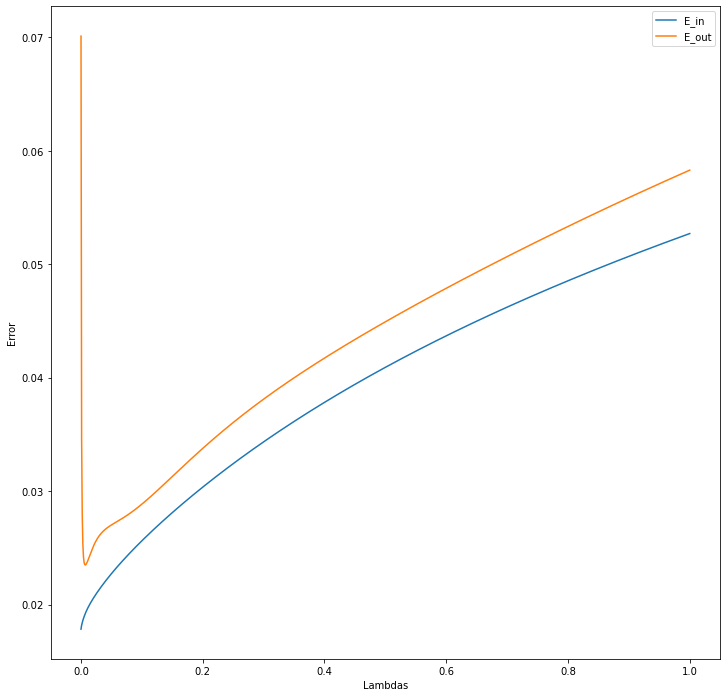

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, train_size=0.8, random_state=5)

kf = KFold(n_splits=10, random_state=None, shuffle=False)

lambda_ein_eval = []

# do KFold for each lambda and get the average ein and eout for each lambda
for l in lambdas:
    ein_for_l = []
    eval_for_l = []
    for train_index, test_index in kf.split(X_train):
        X_train_split, X_validation_split = X_train[train_index], X_train[test_index]
        y_train_split, y_validation_split = y_train[train_index], y_train[test_index]
        w = weights_reg(X_train_split, y_train_split, l)
        ein_for_l.append(calc_error(w, X_train_split, y_train_split))
        eval_for_l.append(calc_error(w, X_validation_split, y_validation_split))
    avg_ein_for_l = np.average(ein_for_l)
    avg_eval_for_l = np.average(eval_for_l)
    lambda_ein_eval.append([l, avg_ein_for_l, avg_eval_for_l])

lambda_ein_eval = np.array(lambda_ein_eval)

figure(figsize=(12, 12))
plt.plot(lambda_ein_eval[:, 0], lambda_ein_eval[:, 1], label='E_in')
plt.plot(lambda_ein_eval[:, 0], lambda_ein_eval[:, 2], label='E_out')
plt.xlabel('Lambdas')
plt.ylabel('Error')
plt.legend()
plt.show()


Minimum E_out: 0.02349457614185828 | E_in: 0.01921038286154886 | Lambda: 0.0071063063063063064


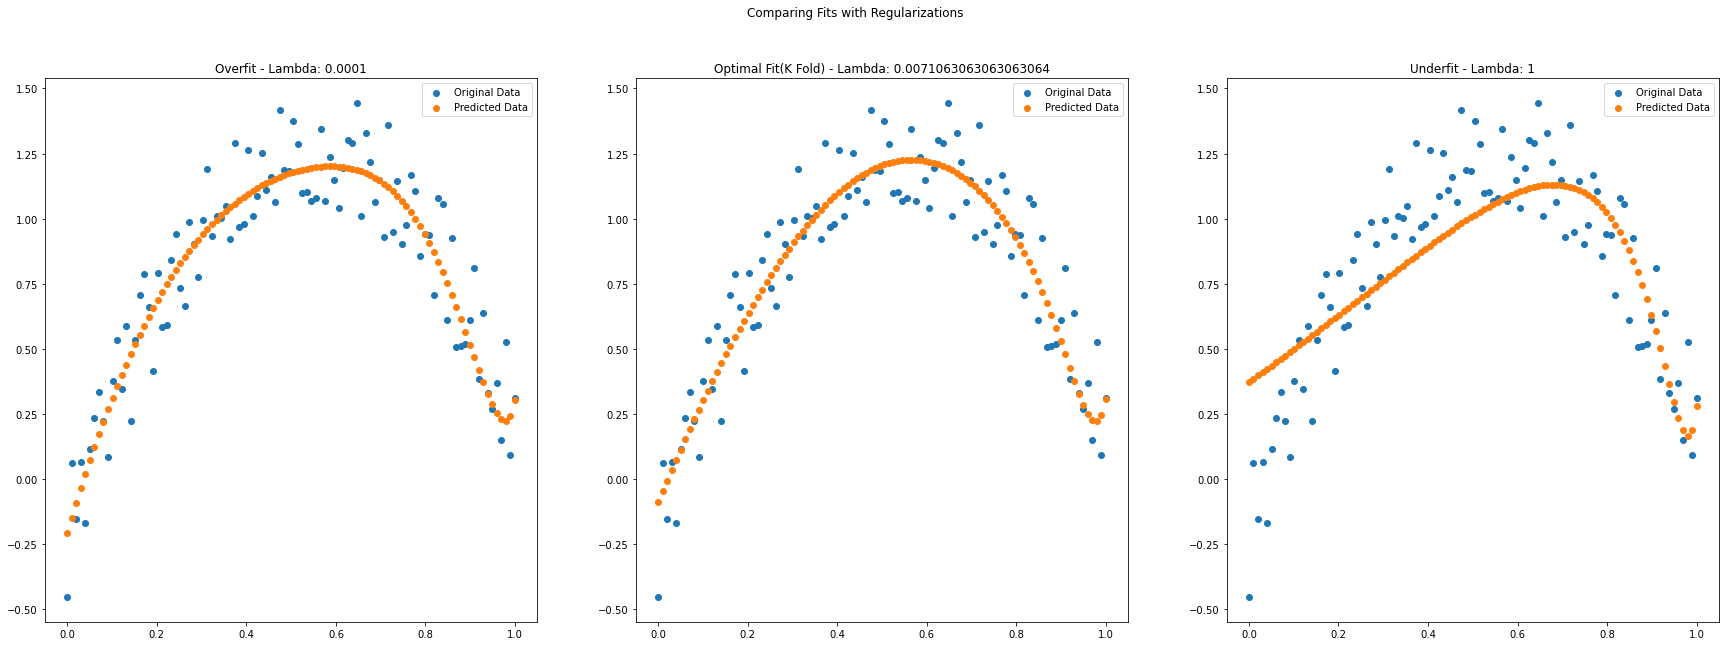

In [20]:
# find the best lambda by using lowest e_out
best_l_ein_eout = lambda_ein_eval[0]
for entry in lambda_ein_eval:
    if best_l_ein_eout[2] > entry[2]:
        best_l_ein_eout = entry

print(f'Minimum E_out: {best_l_ein_eout[2]} | E_in: {best_l_ein_eout[1]} | Lambda: {best_l_ein_eout[0]}')

# plot fit comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparing Fits with Regularizations')
fig.set_figheight(10)
fig.set_figwidth(30)

plot_subplot(ax1, lambda_start, 'Overfit', X_train, y_train)
plot_subplot(ax2, best_l_ein_eout[0], 'Optimal Fit(K Fold)', X_train, y_train)
plot_subplot(ax3, lambda_end, 'Underfit', X_train, y_train)


# Task 4
(Complete by Sunday, Feb 20th)

✔️Use scikit-learn’s RidgeCV and LassoCV to obtain the optimum regularisation using the same transformed data (i.e. features up to 50th order).

- ✔️Observe the resulting error and l (lambda), and compare these to previous results. What do you see? Is this what you expected?
  - 50-50: Error: 0.02576354674577465 | Lambda: 0.02211981981981982
  - KFold: Error: 0.02349457614185828 | Lambda: 0.0071063063063063064
  - Ridge: Error: 0.027425259834631267 | Lambda: 0.0071063063063063064
  - Lasso: Error: 0.03774616150773723 | Lambda: 0.0001
  - We can see that the Error for 50-50 split is higher than the rest of the models/approaches. This is expected because there the rest of the model is trained on full set of traning data. The reason we do that is because the rest are using cross validations. We use all data to get the optimum lambda, and train the model with that lambda.
- ✔️Compare the weights obtained with RidgeCV to those obtained with LassoCV. What do you see? Is this what you expected?
  - As we can see from the last cell in this notebook. LassoCV have many 0 weights. This is expected because Lasso's regularizaer prefers to completely eliminates weight completely.

#### RidgeCV

Minimum Error: 0.027425259834631267 | Lambda: 0.0071063063063063064


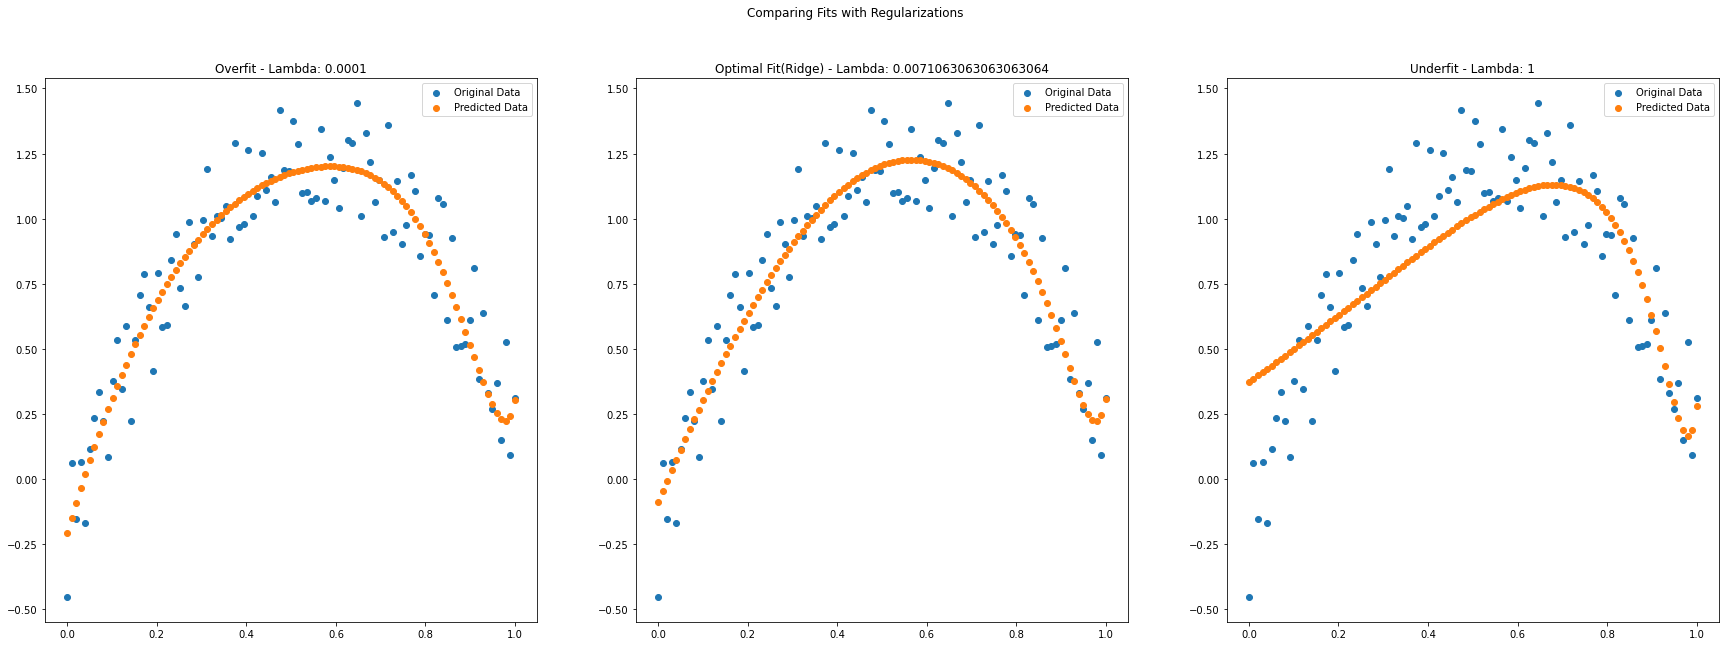

In [21]:
ridge_cv = RidgeCV(alphas=lambdas)
ridge_cv.fit(X_train, y_train)

e_in = calc_error(ridge_cv.coef_, X_train, y_train)
print(f'Minimum Error: {e_in} | Lambda: {ridge_cv.alpha_}')

# plot fit comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparing Fits with Regularizations')
fig.set_figheight(10)
fig.set_figwidth(30)

plot_subplot(ax1, lambda_start, 'Overfit', X_train, y_train)
plot_subplot(ax2, ridge_cv.alpha_, 'Optimal Fit(Ridge)', X_train, y_train)
plot_subplot(ax3, lambda_end, 'Underfit', X_train, y_train)


#### LassoCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018819588434748624, tolerance: 0.0011718890356967882
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1521644114637164, tolerance: 0.0011718890356967882
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011872186253736317, tolerance: 0.001090438776071452
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinat

Minimum Error: 0.03774616150773723 | Lambda: 0.0001


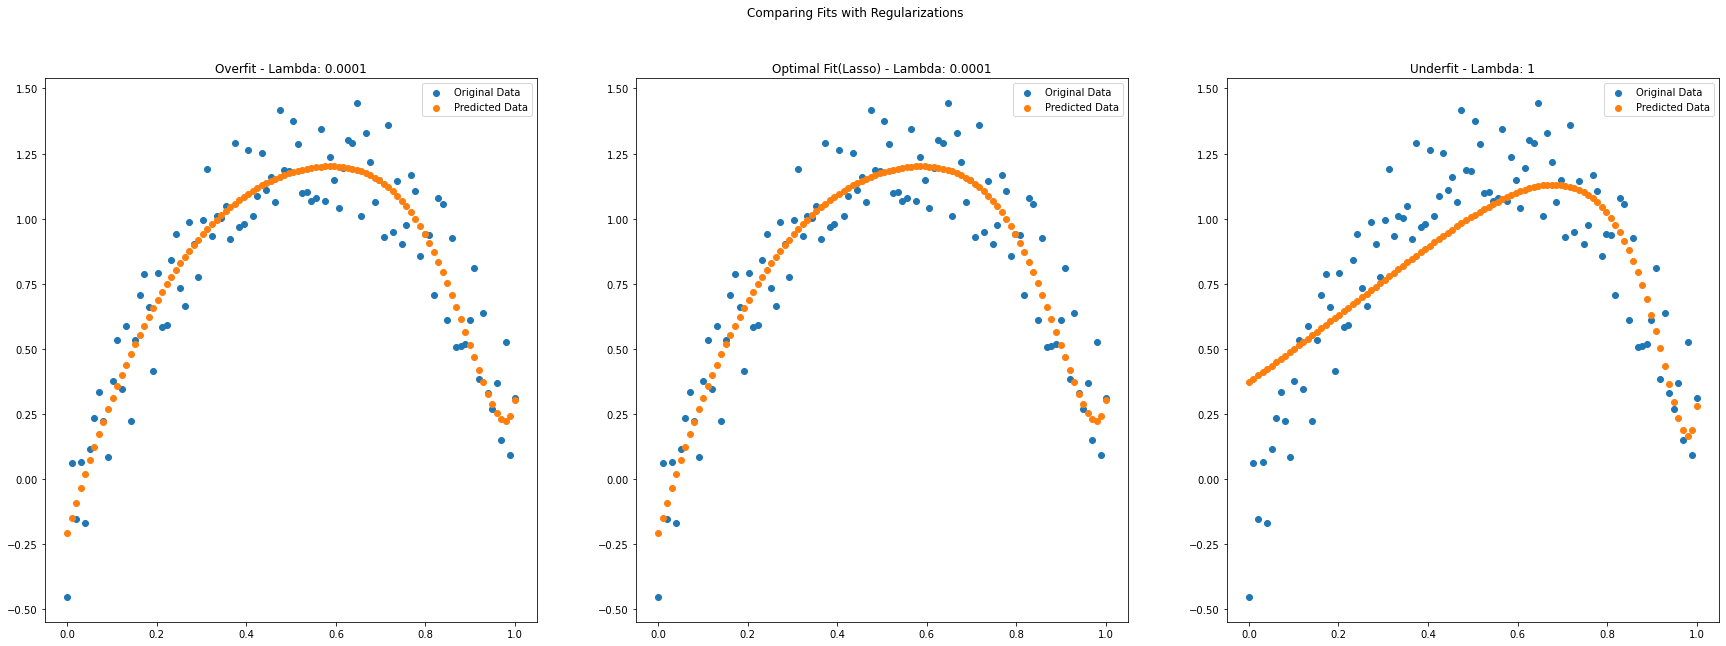

In [22]:
lasso_cv = LassoCV(alphas=lambdas)
lasso_cv.fit(X_train, y_train)

e_in = calc_error(lasso_cv.coef_, X_train, y_train)
print(f'Minimum Error: {e_in} | Lambda: {lasso_cv.alpha_}')

# plot fit comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparing Fits with Regularizations')
fig.set_figheight(10)
fig.set_figwidth(30)

plot_subplot(ax1, lambda_start, 'Overfit', X_train, y_train)
plot_subplot(ax2, lasso_cv.alpha_, 'Optimal Fit(Lasso)', X_train, y_train)
plot_subplot(ax3, lambda_end, 'Underfit', X_train, y_train)


In [23]:
# compare weights of ridge vs lasso
print(ridge_cv.coef_)
print(lasso_cv.coef_)

[ 0.00000000e+00  4.12880168e+00 -2.26969461e+00 -1.46147566e+00
 -4.23722887e-01  7.89322014e-02  2.17065887e-01  1.84536541e-01
  9.52171433e-02  3.52300946e-03 -6.92324374e-02 -1.17925437e-01
 -1.44431242e-01 -1.53052144e-01 -1.48424080e-01 -1.34670789e-01
 -1.15149514e-01 -9.24552286e-02 -6.85217602e-02 -4.47459025e-02
 -2.21037747e-02 -1.24911798e-03  1.74078107e-02  3.36386058e-02
  4.73492364e-02  5.85437182e-02  6.72963845e-02  7.37307325e-02
  7.80032878e-02  8.02913083e-02  8.07834404e-02  7.96726586e-02
  7.71509818e-02  7.34055768e-02  6.86159490e-02  6.29519877e-02
  5.65726784e-02  4.96253382e-02  4.22452557e-02  3.45556416e-02
  2.66678156e-02  1.86815677e-02  1.06856465e-02  2.75833428e-03
 -5.03192021e-03 -1.26258374e-02 -1.99726291e-02 -2.70293219e-02
 -3.37600936e-02 -4.01356306e-02 -4.61325120e-02]
[ 0.00000000e+00  4.76672074e+00 -4.16494462e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.35934850e-02
 -3.25082594e-01 -1.96651213e-01 -3.9292